# Direct and Inverse Steady-State Thermal–Hydraulic Network Problems
## Reproducible Test Case and Reference Implementation

This Jupyter Notebook provides a reproducible reference implementation of the
test case presented in the publication:

**Mirco Ganz, Frank Tillenkamp, Christian Ghiaus**  
*Methodology for solving direct and inverse steady-state thermal–hydraulic network problems*

The notebook accompanies the paper and is intended to allow reviewers and
interested readers to reproduce all numerical results reported in the test case.


## Purpose of this Notebook

The primary purpose of this notebook is to demonstrate how the proposed
methodology can be applied in practice using the provided Python framework.

Specifically, the notebook shows:

- how a steady-state thermo-hydraulic network is constructed from component models,
- how system-level coupling is enforced using junction balance equations,
- how a reduced nonlinear system is obtained using a graph-based tearing strategy,
- how both a **direct problem** and an **inverse problem** are formulated and solved
  within a unified modeling workflow.

All equations, modeling assumptions, and numerical settings correspond exactly
to those described in the paper. No additional modeling assumptions are introduced.


## Scope and Reproducibility

This notebook focuses exclusively on steady-state operation.
Dynamic effects, transient behavior, and control dynamics are intentionally
excluded.

The notebook is designed such that:

- all results can be reproduced by executing the cells from top to bottom,
- all model parameters and solver settings are explicitly defined,
- the structure of the notebook mirrors the structure of the test case
  presented in Sections 3–5 of the paper.

The code cells appearing below correspond to the original implementation
used to generate the results in the publication.


## Methodological Context

Steady-state thermo-hydraulic systems are governed by the conservation of mass,
momentum, and energy. While these physical laws define the system behavior,
they do not prescribe a computational evaluation order.

The proposed methodology combines:

- **causal component models**, evaluated using explicit input–output relations, and
- **acausal system-level coupling**, enforced through implicit junction balance equations.

This hybrid causal–acausal formulation enables flexible system assembly while
maintaining computational efficiency and physical consistency.


## Direct and Inverse Problems

Two classes of computational problems are considered in this notebook.

A **direct problem** is defined as follows:
Given prescribed system inputs, determine all internal system states such that
all component models and junction balance equations are satisfied.

An **inverse problem** arises when desired system outputs are prescribed and
selected system inputs must be determined such that the specified outputs are
achieved while all physical constraints remain satisfied.

In the proposed framework, inverse problems are formulated as constrained
optimization problems and solved within the same modeling environment as
direct problems.


## Implementation Overview

The following sections contain the Python implementation of the test case.

The overall structure follows this sequence:

1. Import of required libraries and framework modules  
2. Definition of model parameters and boundary conditions  
3. Construction of the thermo-hydraulic network  
4. Solution of the direct problem  
5. Solution of the inverse problem  
6. Visualization of results

The code cells below correspond to the original implementation and are
augmented only with additional comments for clarity.


## Framework Import

The following code cell imports the Python framework used to construct and solve
steady-state thermal–hydraulic network models.

The framework provides:

- component models for thermo-hydraulic devices,
- data structures for network and junction representation,
- automatic assembly of system-level balance equations,
- numerical solvers for direct and inverse problem formulations.

All subsequent code cells rely on this framework to define the test system and
to reproduce the results reported in the paper.


In [1]:
# import the framework
from thdin import *

## Network Initialization and Fluid Definition

The thermo-hydraulic system is represented as a network composed of interconnected
components and junctions.

At this stage, an empty network object is created. The network contains one or
more fluid loops, each representing a closed or open flow path of a working fluid
within the system.

Each fluid loop is associated with a specific working fluid. In the present test
case:

- fluid loop 1 corresponds to the refrigerant loop (R134a),
- fluid loops 2 and 3 correspond to the secondary fluid circuits
  (Antifrogen N at 40% concentration).

The fluid loop definitions are required to ensure consistent evaluation of
thermophysical properties throughout the network.



In [2]:
net = Network()

net.fluid_loops[1] = "R134a"
net.fluid_loops[2] = "INCOMP::AN[0.4]"
net.fluid_loops[3] = "INCOMP::AN[0.4]"


## Component Models

The thermo-hydraulic network is constructed from component models representing
the physical devices of the refrigeration system.

Each component is modeled as either:

- a **mass-flow-based component**, or
- a **pressure-based component**,

depending on its computational causality, as described in the paper.

Mass-flow-based components require pressure, specific enthalpy, and mass flow
rate at their inlet ports as inputs and return the corresponding quantities at
their outlet ports.

Pressure-based components require pressure and specific enthalpy at their inlet
and outlet ports and return the associated mass flow rates.

This distinction enables a hybrid causal–acausal formulation in which component
models are evaluated causally, while the system-level coupling is enforced
implicitly through junction balance equations.



In [3]:
# Defining component models of the network

# The dictionary `port_specs` defines the ports of a component and their computational role.

# Each entry maps a user-defined port name to a PortSpec object, which
# specifies whether the port is treated as an inlet ("in") or an outlet ("out")
# with respect to mass, energy, and momentum balance equations.


# Evaporator
evap = MassFlowBasedComponent(
    label="Evap",
    port_specs={
        "in_af":  PortSpec("in"),
        "out_af": PortSpec("out"),
        "in_r": PortSpec("in"),
        "out_r":PortSpec("out"),
    },
)

# Compressor
comp = PressureBasedComponent(
    label="Comp",
    port_specs={
        "in":  PortSpec("in"),
        "out": PortSpec("out"),
    },
)

# Condenser
cond = MassFlowBasedComponent(
    label="Cond",
    port_specs={
        "in_r":  PortSpec("in"),
        "out_r": PortSpec("out"),
        "in_af": PortSpec("in"),
        "out_af":PortSpec("out"),
    },
)

# Expansion Valve
exp = PressureBasedComponent(
    label="Exp",
    port_specs={
        "in":  PortSpec("in"),
        "out": PortSpec("out"),
    },
)

# Receiver
rev = MassFlowBasedComponent(
    label="Rev",
    port_specs={
        "in":  PortSpec("in"),
        "out": PortSpec("out"),
    },
)

# Internal Heat Exchanger
ihx = MassFlowBasedComponent(
    label="IHX",
    port_specs={
        "in_hot":  PortSpec("in"),
        "out_hot": PortSpec("out"),
        "in_cold": PortSpec("in"),
        "out_cold":PortSpec("out"),
    },
)

# adds components to the network
net.add_component(comp)
net.add_component(cond)
net.add_component(evap)
net.add_component(exp)
net.add_component(ihx)
net.add_component(rev)


## Component Model Formulation

In this section, the numerical models of all components forming the
thermo-hydraulic network are defined.

Each component model represents a steady-state control volume and enforces
mass, momentum, and energy conservation in accordance with the methodology
described in the paper.

All component models are formulated **causally**: for a given set of input
variables at the component ports, the corresponding output variables are
computed explicitly. System-level coupling and physical consistency are
enforced separately through junction balance equations.


## Modeling Assumptions

The component models implemented below follow the assumptions introduced
in Section 4 of the paper:

- steady-state operation,
- one-dimensional flow,
- negligible kinetic and potential energy changes,
- no pressure losses in heat exchangers and the receiver,
- heat transfer modeled using lumped or discretized formulations.

Thermophysical properties are evaluated using CoolProp.


## Component-Specific Modeling Approaches

The following modeling approaches are used:

- **Evaporator and condenser**  
  Modeled as mass-flow-based components using a finite-volume discretization
  of the steady-state energy balance along the heat exchanger length.
  A shooting method is applied to satisfy boundary conditions at both ends.

- **Compressor**  
  Modeled as a pressure-based component using manufacturer-derived correlations
  for volumetric and isentropic efficiency.

- **Expansion valve**  
  Modeled as a pressure-based component assuming isenthalpic expansion and
  a square-root relationship between mass flow rate and pressure drop.

- **Receiver**  
  Modeled as a mass-flow-based component enforcing saturated liquid conditions
  at the outlet.

- **Internal heat exchanger (IHX)**  
  Modeled as a mass-flow-based component using the ε–NTU method.


## Callable Component Models

Within the framework, component models are implemented as **callable Python
functions**.

Each component model:

- takes a component object as its single input argument,
- reads the required input variables from the component’s ports and parameters,
- computes the corresponding output variables,
- writes the results back to the component’s output ports.

This design allows component models to be treated as modular, reusable
computational blocks that can be evaluated independently, while their
interaction and consistency are enforced at the system level through junction
balance equations.


In [4]:
# Evaporator model
def evap_model(evap):
    
    # Finite-volume discretization of the steady-state energy balance
    # Shooting method used to satisfy outlet boundary condition

    N = 50

    A = evap.parameter['A'].value
    U = cond.parameter['U'].value

    hi_h = evap.ports['in_af'].h.value
    pi_h = evap.ports['in_af'].p.value
    m_h = evap.ports['in_af'].m.value
    hot_fluid = evap.ports['in_af'].fluid

    hi_c = evap.ports['in_r'].h.value
    pi_c = evap.ports['in_r'].p.value
    m_c = evap.ports['in_r'].m.value
    cold_fluid = evap.ports['in_r'].fluid

    def res(x):
        h_h = np.zeros(N)
        h_c = np.zeros(N)
        h_c[0] = hi_c
        h_h[0] = x[0] * 1e5
        for i in range(N - 1):
            Th = PropsSI('T', 'H', h_h[i], 'P', pi_h, hot_fluid)
            Tc = PropsSI('T', 'H', h_c[i], 'P', pi_c, cold_fluid)
            h_h[i + 1] = h_h[i] + U * A / N * (Th - Tc) / m_h
            h_c[i + 1] = h_c[i] + U * A / N * (Th - Tc) / m_c
        return np.array([(h_h[-1] - hi_h) * 1e-5])

    Ti_c = PropsSI('T', 'H', hi_c, 'P', pi_c, cold_fluid)
    ho_h_init = PropsSI('H', 'P', pi_h, 'T', max(Ti_c, 257.0), hot_fluid) * 1e-5
    sol = scipy.optimize.root(res, np.array([ho_h_init]), method='hybr', tol=1e-5)

    if sol.success:
        ho_h = sol.x[0] * 1e5
        h_h = np.zeros(N)
        h_c = np.zeros(N)
        h_c[0] = hi_c
        h_h[0] = ho_h
        for i in range(N - 1):
            Th = PropsSI('T', 'H', h_h[i], 'P', pi_h, hot_fluid)
            Tc = PropsSI('T', 'H', h_c[i], 'P', pi_c, cold_fluid)
            h_h[i + 1] = h_h[i] + U * A / N * (Th - Tc) / m_h
            h_c[i + 1] = h_c[i] + U * A / N * (Th - Tc) / m_c
    else:
        raise Exception(sol.message)

    po_h = pi_h
    ho_h = h_h[0]
    mo_h = m_h

    po_c = pi_c
    ho_c = h_c[-1]
    mo_c = m_c

    evap.ports['out_af'].p.set_value(po_h)
    evap.ports['out_af'].h.set_value(ho_h)
    evap.ports['out_af'].m.set_value(mo_h)

    evap.ports['out_r'].p.set_value(po_c)
    evap.ports['out_r'].h.set_value(ho_c)
    evap.ports['out_r'].m.set_value(mo_c)

    evap.outputs["Q"].set_value(m_c * (ho_c - hi_c))
    
# Condenser mode
def cond_model(cond):
    
    # Finite-volume discretization of the steady-state energy balance
    # Shooting method used to satisfy outlet boundary condition
    
    N = 50

    A = cond.parameter['A'].value
    U = cond.parameter['U'].value

    hi_h = cond.ports["in_r"].h.value
    pi_h = cond.ports["in_r"].p.value
    m_h = cond.ports["in_r"].m.value
    hot_fluid = cond.ports["in_r"].fluid

    hi_c = cond.ports["in_af"].h.value
    pi_c = cond.ports["in_af"].p.value
    m_c = cond.ports["in_af"].m.value
    cold_fluid = cond.ports["in_af"].fluid

    def res(x):
        h_h = np.zeros(N)
        h_c = np.zeros(N)
        h_h[0] = hi_h
        h_c[0] = x[0] * 1e5
        for i in range(N - 1):
            Th = PropsSI('T', 'H', h_h[i], 'P', pi_h, hot_fluid)
            Tc = PropsSI('T', 'H', h_c[i], 'P', pi_c, cold_fluid)
            h_h[i + 1] = h_h[i] - U * A / N * (Th - Tc) / m_h
            h_c[i + 1] = h_c[i] - U * A / N * (Th - Tc) / m_c
        return np.array([(h_c[-1] - hi_c) * 1e-5])

    Ti_h = PropsSI('T', 'H', hi_h, 'P', pi_h, hot_fluid)
    ho_c_init = PropsSI('H', 'P', pi_c, 'T', min(Ti_h, 350.0), cold_fluid) * 1e-5
    sol = scipy.optimize.root(res, np.array([ho_c_init]), method='hybr', tol=1e-5)

    if sol.success:
        ho_c = sol.x[0] * 1e5
        h_h = np.zeros(N)
        h_c = np.zeros(N)
        h_h[0] = hi_h
        h_c[0] = ho_c
        for i in range(N - 1):
            Th = PropsSI('T', 'H', h_h[i], 'P', pi_h, hot_fluid)
            Tc = PropsSI('T', 'H', h_c[i], 'P', pi_c, cold_fluid)
            h_h[i + 1] = h_h[i] - U * A / N * (Th - Tc) / m_h
            h_c[i + 1] = h_c[i] - U * A / N * (Th - Tc) / m_c
    else:
        raise Exception(sol.message)

    po_h = pi_h
    ho_h = h_h[-1]
    mo_h = m_h

    po_c = pi_c
    ho_c = h_c[0]
    mo_c = m_c

    cond.ports["out_r"].p.set_value(po_h)
    cond.ports["out_r"].h.set_value(ho_h)
    cond.ports["out_r"].m.set_value(mo_h)

    cond.ports["out_af"].p.set_value(po_c)
    cond.ports["out_af"].h.set_value(ho_c)
    cond.ports["out_af"].m.set_value(mo_c)

# Compressor model
def comp_model(comp):
    
    # Model using volumetric and isentropic efficiency maps
    
    n = 4 # number of cylinders
    bore = 0.06 # bore [m]
    stroke = 0.042 # stroke [m]
    Vd = n * bore**2 * np.pi / 4 * stroke # displacement volume

    a = np.array([-5.31166292e-02, 1.21402922e-03, 8.81226071e-05, 1.03163725e+00])
    b = np.array([9.38116126e-03, -1.52858792e-03, -4.08026601e-03, 6.31332600e-04, 6.77625196e-01])

    RPM = comp.parameter['RPM'].value
    hi = comp.ports['in'].h.value
    pi = comp.ports['in'].p.value
    po = comp.ports['out'].p.value
    fluid = comp.ports['in'].fluid

    eta_v = a[0] * (po / pi) + a[1] * (po / pi) ** 2 + a[2] * (RPM / 60) + a[3]
    eta_is = b[0] * (po / pi) + b[1] * (po / pi) ** 2 + b[2] * (RPM / 60) + b[3] * (po / pi) * (RPM / 60) + b[4]

    s = PropsSI('S', 'P', pi, 'H', hi, fluid)
    h_is = PropsSI('H', 'P', po, 'S', s, fluid)
    rho = PropsSI('D', 'P', pi, 'H', hi, fluid)
    ho = hi + (h_is - hi) / eta_is
    mi = mo = RPM / 60 * Vd * eta_v * rho

    comp.ports['in'].m.set_value(mi)
    comp.ports['out'].h.set_value(ho)
    comp.ports['out'].m.set_value(mo)

# Expansion valve model
def exp_model(exp):
    
    # Orifice-based steady-state expansion valve model assuming isenthalpic expansion

    Cf = exp.parameter['Cf'].value
    Av = exp.parameter['Av'].value
    hi = exp.ports["in"].h.value
    pi = exp.ports["in"].p.value
    po = exp.ports["out"].p.value
    fluid = exp.ports["in"].fluid

    rho = PropsSI('D', 'P', pi, 'H', hi, fluid)
    pressure_difference = (pi - po) * 1e-5
    n = pressure_difference * 1000 * rho
    m = Cf * Av * np.sqrt(n) / 3600
    ho = hi
    mi = mo = m

    exp.ports["in"].m.set_value(mi)
    exp.ports["out"].h.set_value(ho)
    exp.ports["out"].m.set_value(mo)

# Receiver model
def rev_model(rev):

    p_in = rev.ports["in"].p.value
    m_in = rev.ports["in"].m.value
    fluid = rev.ports["in"].fluid
    p_out = p_in
    h_out = PropsSI('H', 'P', p_in, 'Q', 0.0, fluid)
    m_out = m_in
    rev.ports["out"].p.set_value(p_out)
    rev.ports["out"].h.set_value(h_out)
    rev.ports["out"].m.set_value(m_out)

# Internal heat exchanger model
def ihx_model(ihx):
    
     # Model based on the epsilon–NTU method

    A = ihx.parameter['A'].value
    U = ihx.parameter['U'].value 

    hi_h = ihx.ports["in_hot"].h.value - 1e-3
    pi_h = ihx.ports["in_hot"].p.value
    mi_h = ihx.ports["in_hot"].m.value
    hot_fluid = ihx.ports["in_hot"].fluid

    hi_c = ihx.ports["in_cold"].h.value + 1e-3
    pi_c = ihx.ports["in_cold"].p.value
    mi_c = ihx.ports["in_cold"].m.value
    cold_fluid = ihx.ports["in_cold"].fluid

    C_h = mi_h * PropsSI('C', 'P', pi_h, 'H', hi_h, hot_fluid)
    C_c = mi_c * PropsSI('C', 'P', pi_c, 'H', hi_c, cold_fluid)
    T_in_h = PropsSI('T', 'P', pi_h, 'H', hi_h, hot_fluid)
    T_in_c = PropsSI('T', 'P', pi_c, 'H', hi_c, cold_fluid)

    R = C_h / C_c
    NTU = U * A / C_h
    n = (-1) * NTU * (1 + R)
    epsilon = (1 - np.exp(n)) / (1 + R)
    Q = epsilon * C_h * (T_in_h - T_in_c)

    po_c = pi_c
    po_h = pi_h
    ho_h = (hi_h - Q / mi_h)
    ho_c = (hi_c + Q / mi_c)
    mo_h = mi_h
    mo_c = mi_c

    ihx.ports["out_hot"].p.set_value(po_h)
    ihx.ports["out_hot"].h.set_value(ho_h)
    ihx.ports["out_hot"].m.set_value(mo_h)

    ihx.ports["out_cold"].p.set_value(po_c)
    ihx.ports["out_cold"].h.set_value(ho_c)
    ihx.ports["out_cold"].m.set_value(mo_c)


## Assignment of Component Models to Network Elements

After defining the callable component model functions, each model is assigned
to its corresponding component within the network.

This assignment establishes the link between:

- the **component object**, which represents a node in the thermo-hydraulic network,
- and the **component model function**, which defines how the component is evaluated
  numerically.

During the solution of the direct or inverse problem, the network solver invokes
the assigned component model functions whenever the corresponding component
needs to be evaluated. Inputs are read from the component ports and parameters,
and the computed outputs are written back to the ports.

This separation between component definition and component model assignment
allows different modeling approaches to be tested without modifying the network
topology.


In [5]:
# sets the model to each component
net.set_component_model("Comp", comp_model)
net.set_component_model("Cond", cond_model)
net.set_component_model("Evap", evap_model)
net.set_component_model("Exp", exp_model)
net.set_component_model("IHX", ihx_model)
net.set_component_model("Rev", rev_model)

## Network Connections and Junction Definition

The individual components are now interconnected to form the thermo-hydraulic
network corresponding to the refrigeration cycle shown in Figure 9 of the paper.

Connections between component ports are defined using the `net.connect` method.
Each connection represents a junction at which the following physical conditions
are enforced implicitly:

- conservation of mass,
- conservation of energy,
- continuity of pressure.

The argument `fluid_loop` assigns each connection to a specific fluid loop,
ensuring that only ports belonging to the same working fluid are coupled.


In [6]:
# The function `net.connect` defines a junction between two component ports.
#
# Each call connects an inlet or outlet port of one component with a port of
# another component. At the resulting junction, mass and energy conservation
# as well as pressure continuity are enforced automatically by the framework.

net.connect("IHX", "out_cold", "Comp", "in",  fluid_loop=1)
net.connect("Comp", "out", "Cond", "in_r",   fluid_loop=1)
net.connect("Cond", "out_r", "Rev", "in", fluid_loop=1)
net.connect("Rev", "out", "IHX", "in_hot", fluid_loop=1)
net.connect("IHX", "out_hot", "Exp", "in", fluid_loop=1)
net.connect("Exp", "out", "Evap", "in_r", fluid_loop=1)
net.connect("Evap", "out_r", "IHX", "in_cold", fluid_loop=1)


## Model Parameters and Outputs

In addition to the network topology and component models, the framework requires
the explicit declaration of model parameters and system outputs.

**Model parameters** represent quantities that are required by the component
models during evaluation but are not part of the system state vector.
Typical examples include geometric parameters, control variables, or empirical
coefficients.

**System outputs** represent quantities of interest that are computed once the
network equations have been solved. These outputs are not used to enforce
physical consistency, but are extracted for analysis, visualization, or use
in inverse problem formulations.

In the following code cell, all parameters and outputs required for the test
case are registered at the network level.



In [7]:
# The function `net.add_parameter` registers component-specific model parameters
# at the network level.
#
# Parameters represent constant or control variables that are not part of the
# system state vector, but are required by the component models during evaluation.
#
# Each parameter is identified by the component label and the parameter name
# used inside the corresponding component model.

net.add_parameter("Comp", "RPM")

net.add_parameter("Cond", "A")
net.add_parameter("Cond", "U")

net.add_parameter("Evap", "A")
net.add_parameter("Evap", "U")

net.add_parameter("IHX", "A")
net.add_parameter("IHX", "U")

net.add_parameter("Exp", "Cf")
net.add_parameter("Exp", "Av")


# The function `net.add_output` registers component-level quantities of interest
# as system outputs.
#
# Registered outputs are evaluated after the solution of the network equations
# and can be used for post-processing, visualization, or inverse problem
# formulations.
net.add_output(comp_label='Evap', output_label='Q')
net.add_output(comp_label="Cond", output_label='Q')
net.add_output(comp_label="Comp", output_label='P')


## Loop Breaker in Closed Fluid Loops

The refrigerant circuit of the test system forms a closed fluid loop.
In such loops, the full set of junction mass balance equations is linearly
dependent.

The framework therefore introduces the concept of a **loop breaker**.

A loop breaker removes the **mass balance equation** at one user-selected
junction of a closed fluid loop. The junction at which the mass balance is
removed is explicitly specified by the user.

At this stage, the resulting system is **not yet well-posed**, as one equation
has been removed without introducing a replacement constraint.

The number and type of additional constraint equations required to close the
system cannot be determined a priori. This information becomes available only
after the tearing algorithm has identified the tearing variables and the
corresponding set of residual equations.

The definition of appropriate constraint equations is therefore deferred to
a subsequent step.


In [8]:
# adds loop breaker to remove redundant mass balance equation from closed fluid loop
net.add_loop_breaker(fluid_loop=1, junction_id=1)

## Network Initialization and Tearing

After the network topology, component models, parameters, outputs, and loop
breakers have been defined, the network is initialized.

During initialization, the framework analyzes the network graph and applies
a tearing algorithm to:

- identify the system state variables,
- determine the tearing variables,
- construct the corresponding set of residual equations.

At this stage, the residual system reflects only the structural balance
equations implied by the network topology and component interconnections.

No additional constraint equations are introduced during initialization.


In [9]:
# Initialize the network:
# - apply the tearing algorithm
# - identify tearing variables and residual equations
net.initialize()

## Identified Tearing Variables

After network initialization, the tearing algorithm has identified the set of
tearing variables that parameterize the reduced nonlinear system.

Tearing variables represent a subset of the system variables whose values are
sufficient to reconstruct all remaining variables through causal evaluation
of the component models.

For transparency and reproducibility, the identified tearing variables are
printed to the console.


In [10]:
# prints tearing variables to the console
net.print_tearing_variables()

Tearing variables:
p(in) at component <Comp> , port <in>
h(in) at component <Comp> , port <in>
p(out) at component <Comp> , port <out>
p(in) at component <Exp> , port <in>
h(in) at component <Exp> , port <in>
p(out) at component <Exp> , port <out>


In this case, the tearing algorithm identifies the following tearing variables:

- Inlet port pressure of the compressor: $p_{i,\mathrm{comp}}$
- Inlet port specific enthalpy of the compressor: $h_{i,\mathrm{comp}}$
- Outlet port pressure of the compressor: $p_{o,\mathrm{comp}}$
- Inlet port pressure of the expansion valve: $p_{i,\mathrm{exp}}$
- Inlet port specific enthalpy of the expansion valve: $h_{i,\mathrm{exp}}$
- Outlet port pressure of the expansion valve: $p_{o,\mathrm{exp}}$

These variables parameterize the reduced nonlinear system obtained after tearing.
They can be collected in the tearing variable vector


$\mathbf{z}=
\begin{bmatrix}
p_{i,\mathrm{comp}} &
h_{i,\mathrm{comp}} &
p_{o,\mathrm{comp}} &
p_{i,\mathrm{exp}} &
h_{i,\mathrm{exp}} &
p_{o,\mathrm{exp}}
\end{bmatrix}^{\top}.
$

The ordering of the variables corresponds to the internal ordering used by the
framework.




## Initial Values and Bounds for Tearing Variables

To solve the reduced nonlinear system, initial values and bounds must be
provided for all tearing variables.

The initial values serve as a starting point for the nonlinear solver.
The bounds restrict the admissible range of the tearing variables and ensure
physically meaningful solutions during the solution process.

In [11]:
# x_init = [2e5, 4e5, 1e6, 1e6, 2.5e5, 2e5]
x_init = [1.6e5, 4.1e5, 7.9e5, 7.9e5, 2.2e5, 1.6e5]
x_bnds = [(1e5, 4e5), (2e5, 6e5), (5e5, 30e5), (5e5, 30e5), (1e5, 3.5e5), (1e5, 4e5)]

net.set_inital_values(x_init, x_bnds)

### Residual Equations Identified by the Tearing Algorithm

After identifying the tearing variables, the corresponding residual equations
of the reduced system can be inspected.

The following command prints the residual equations generated by the tearing
algorithm based on the network topology, junction definitions, and the applied
loop breaker.



In [12]:
net.print_residual_equations()

Residual equations:
Pressure Equality at junction 1
Enthalpy Equality at junction 1
Pressure Equality at junction 5
Enthalpy Equality at junction 5
Mass Flow Balance at junction 5


The residual equations of the network are therefore given by

$\mathbf{r}(\mathbf{z} \mid \mathbf{u}) = \mathbf{0}
\quad \Leftrightarrow \quad
\left\{
\begin{aligned}
    p_{i,\mathrm{co}} - p_{o,\mathrm{ihx},c} &= 0, \\
    h_{i,\mathrm{co}} - h_{o,\mathrm{ihx},c} &= 0, \\
    p_{i,\mathrm{exp}} - p_{o,\mathrm{ihx},h} &= 0, \\
    h_{i,\mathrm{exp}} - h_{o,\mathrm{ihx},h} &= 0, \\
    \dot{m}_{i,\mathrm{exp}} - \dot{m}_{o,\mathrm{ihx},h} &= 0.
\end{aligned}
\right.
$

where it is indicated that the residual equations always depend on the system
inputs $\mathbf{u}$.

We observe that the system contains six unknown tearing variables but only five
residual equations. This is a direct consequence of the loop breaker applied to
the closed refrigerant loop, which removes one mass balance equation from the
system.


We see that we have 6 unknown tearing variables but only 5 residual equations. Thats due to the fact that we need to add a loop breaker to the closed loop because of the overdetermined mass balance equations.


### Additional Constraint Equation

As shown above, the reduced system obtained after tearing contains six unknown
tearing variables but only five residual equations. An additional constraint
equation is therefore required to close the system.

In this test case, the receiver outlet specific enthalpy $h_{o,\mathrm{rev}}$
depends only on the pressure level inside the receiver $p_{\mathrm{rev}}$.
As a result, energy conservation is not automatically enforced unless both the
inlet and outlet specific enthalpies of the receiver equal the specific enthalpy
of saturated liquid at the receiver pressure, i.e.,

$h_{o,\mathrm{rev}} = h_{i,\mathrm{rev}} = h_s(p_{\mathrm{rev}})$.

From the energy balance at the junction between the condenser outlet and the
receiver inlet, it follows that

$h_{i,\mathrm{rev}} = h_{o,\mathrm{cond}}$.

This implies that the condenser outlet enthalpy must also match the saturation
enthalpy at the receiver pressure to ensure consistency and prevent energy
imbalances in steady-state operation.

Accordingly, the following constraint equation is introduced:

$h_{o,\mathrm{cond}} - h_s\!\left(p_{o,\mathrm{cond}}\right) = 0$.

Such a constraint can be readily implemented within the framework, as shown
in the following.



In [13]:
# The constraint is defined as a callable Python function.
#
# The function takes the initialized network object as input, accesses the
# current values of the relevant component ports, and returns the residual
# of the constraint equation.
#
# The returned value is treated as an equality constraint (ctype="eq") by the solver.

def sat_con(net):
    h_s = PropsSI('H', 'P', net.components['Cond'].ports["out_r"].p.value,
                  'Q', 0.0, net.components['Cond'].ports["out_r"].fluid)
    res = (net.components['Cond'].ports["out_r"].h.value - h_s)
    return res

# adds constraint to the network
net.add_constraint("saturation_constraint", sat_con, ctype='eq', scale_factor=1e-5)

## Direct Problem Formulation

We first consider the **direct problem**. In this case, the objective is to
compute the complete steady-state thermo-hydraulic state of the system as well
as selected system outputs, given prescribed system inputs.

The system state vector $\mathbf{x}$ contains all pressures, specific
enthalpies, and mass flow rates at the inlet and outlet ports of all components.
The system outputs include the evaporator and condenser heat loads,
$\dot{Q}_{\mathrm{evap}}$ and $\dot{Q}_{\mathrm{cond}}$, as well as the
compressor power consumption $P_{\mathrm{comp}}$.

The system inputs are given by

$\mathbf{u}=
\begin{bmatrix}
\omega &
A_v &
p_{i,\mathrm{af,evap}} &
h_{i,\mathrm{af,evap}} &
\dot{m}_{i,\mathrm{af,evap}} &
p_{i,\mathrm{af,cond}} &
h_{i,\mathrm{af,cond}} &
\dot{m}_{i,\mathrm{af,cond}}
\end{bmatrix}^{\top},$

while the output vector is defined as

$
\mathbf{y}=
\begin{bmatrix}
\dot{Q}_{\mathrm{evap}} &
\dot{Q}_{\mathrm{cond}} &
P_{\mathrm{comp}}
\end{bmatrix}^{\top}.
$


The direct problem is formulated as follows.

Given the system inputs $\mathbf{u}$, the tearing variables $\mathbf{z}$
are obtained by solving the reduced nonlinear system

$\mathbf{r}(\mathbf{z} \mid \mathbf{u}) = \mathbf{0}
\quad \Leftrightarrow \quad
\left\{
\begin{aligned}
    p_{i,\mathrm{co}} - p_{o,\mathrm{ihx},c} &= 0, \\
    h_{i,\mathrm{co}} - h_{o,\mathrm{ihx},c} &= 0, \\
    p_{i,\mathrm{exp}} - p_{o,\mathrm{ihx},h} &= 0, \\
    h_{i,\mathrm{exp}} - h_{o,\mathrm{ihx},h} &= 0, \\
    \dot{m}_{i,\mathrm{exp}} - \dot{m}_{o,\mathrm{ihx},h} &= 0.
\end{aligned}
\right.$

For a solution $\mathbf{z}^*$ of this system, the corresponding internal
system variables and outputs are obtained through the mapping

$\begin{bmatrix} \mathbf{x} \\ \mathbf{y} \end{bmatrix} = \boldsymbol{\psi}(\mathbf{z}^*, \mathbf{u})$

where $\boldsymbol{\psi}(\cdot)$ denotes the forward evaluation of the
component models and junction balance equations.

In other words, the direct problem consists in determining all pressures,
specific enthalpies, and mass flow rates at the component ports, as well as the
system outputs, such that all steady-state mass and energy balance equations and
pressure continuity conditions at the junctions are satisfied for a given set
of system inputs.

In this case, the physical causality of the system coincides with the
computational causality imposed by the component models. The problem therefore
constitutes a direct problem.


### Boundary Conditions

To solve the direct problem within the framework, boundary conditions must be
assigned to the system.

Due to the causal structure of the component models, certain ports are not
connected to junctions but instead represent component inputs. The variables at
these ports must therefore be prescribed explicitly.

In the present test case, boundary conditions are required for the following
ports:

- Antifrogen inlet port of the evaporator:
  $p_{i,\mathrm{af,evap}}, h_{i,\mathrm{af,evap}}, \dot{m}_{i,\mathrm{af,evap}}$

- Antifrogen inlet port of the condenser:
  $p_{i,\mathrm{af,cond}}, h_{i,\mathrm{af,cond}}, \dot{m}_{i,\mathrm{af,cond}}$

These boundary conditions are assigned in the following code cell.


In [14]:
# Assignment of boundary conditions for the direct problem.
#
# The boundary conditions correspond to system inputs that are not determined
# by junction balance equations, but are required as inputs by the causal
# component models.
#
# These values define the system input vector u and remain fixed during the
# solution of the direct problem.
#
# In the present test case, boundary conditions are assigned to the antifrogen
# inlet ports (labeled by 'in_af') of the evaporator and the condenser.


# Boundary conditions at the evaporator antifrogen inlet port
hi_evap_af = PropsSI("H", "P", 1e5, "T", -5.0+273.15, net.fluid_loops[2])
net.set_bc("Evap", "in_af", "p", 1e5, fluid_loop=2)
net.set_bc("Evap", "in_af", "h", hi_evap_af, fluid_loop=2)
net.set_bc("Evap", "in_af", "m", 1.0, fluid_loop=2)

# Boundary conditions at the condenser antifrogen inlet port
hi_cond_af = PropsSI("H", "P", 1e5, "T", 27.0+273.15, net.fluid_loops[3])
net.set_bc("Cond", "in_af", "p", 1e5, fluid_loop=3)
net.set_bc("Cond", "in_af", "h", hi_cond_af, fluid_loop=3)
net.set_bc("Cond", "in_af", "m", 1.0, fluid_loop=3)

### Specification of System Inputs and Parameter for the Direct Problem

The direct problem is solved for a specific set of system inputs and parameters.
In this step, numerical values are assigned to the model parameters that
constitute the system input vector $\mathbf{u}$.

These values define the operating point of the system and remain fixed during
the solution of the direct problem.


In [15]:
# Compressor operating speed
net.set_parameter("Comp", "RPM", value=2500)

# Expansion valve parameters
net.set_parameter("Exp", "Av", value=0.3)
net.set_parameter("Exp", "Cf", value=0.25)

# Heat transfer areas and overall heat transfer coefficients
# of condenser
net.set_parameter("Cond", "A", value=3.65)
net.set_parameter("Cond", "U", value=1000)

# evaporator
net.set_parameter("Evap", "A", value=2.56)
net.set_parameter("Evap", "U", value=1000)

# internal heat exchanger
net.set_parameter("IHX", "A", value=0.75)
net.set_parameter("IHX", "U", value=1000)


### Solution of the Direct Problem
The direct problem is solved by computing the tearing variables
$\mathbf{z}$ such that the reduced residual system

$\mathbf{r}(\mathbf{z} \mid \mathbf{u}) = \mathbf{0}$

is satisfied for the specified system inputs $\mathbf{u}$.

Once a solution for the tearing variables has been obtained, all remaining
internal system variables and outputs are reconstructed automatically by
forward evaluation of the component models.


In [16]:
# Solve the direct problem.
# Upon convergence, the complete steady-state system state and all registered
# outputs are available for post-processing.

net.solve_system_notebook()


 Start solver...

 Solver converged successfully
 message: The solution converged.
 success: True
  status: 1
     fun: [ 0.000e+00  1.217e-13  0.000e+00  2.061e-13  5.985e-13
            5.781e-10]
       x: [ 1.030e+00  4.185e+00  8.012e+00  8.012e+00  2.248e+00
            1.030e+00]
  method: hybr
    nfev: 30
    fjac: [[-7.609e-01  7.043e-02 ... -6.302e-01  5.433e-02]
           [-1.844e-01 -9.759e-01 ...  1.114e-01  2.671e-02]
           ...
           [ 6.139e-02 -2.112e-02 ...  1.205e-01 -2.153e-02]
           [-6.185e-01  2.034e-01 ...  7.563e-01 -3.670e-02]]
       r: [-1.314e+00  2.516e-01 ... -5.917e-02  6.557e-01]
     qtf: [ 6.286e-10  3.112e-10 -8.516e-09 -7.967e-09 -2.463e-10
           -4.200e-10]


In [17]:
res = net.get_results()

p1 = res["ports"]["Comp"]["in"]["p"]
p2 = res["ports"]["Comp"]["out"]["p"]
h1 = res["ports"]["Comp"]["in"]["h"]
h2 = res["ports"]["Comp"]["out"]["h"]

p3 = res["ports"]["Cond"]["out_r"]["p"]
h3 = res["ports"]["Cond"]["out_r"]["h"]

p4 = res["ports"]["Rev"]["out"]["p"]
h4 = res["ports"]["Rev"]["out"]["h"]

p5 = res["ports"]["IHX"]["out_hot"]["p"]
h5 = res["ports"]["IHX"]["out_hot"]["h"]

p6 = res["ports"]["Exp"]["out"]["p"]
h6 = res["ports"]["Exp"]["out"]["h"]

p7 = res["ports"]["Evap"]["out_r"]["p"]
h7 = res["ports"]["Evap"]["out_r"]["h"]

m_close_loop = res["ports"]["Comp"]["in"]["m"]



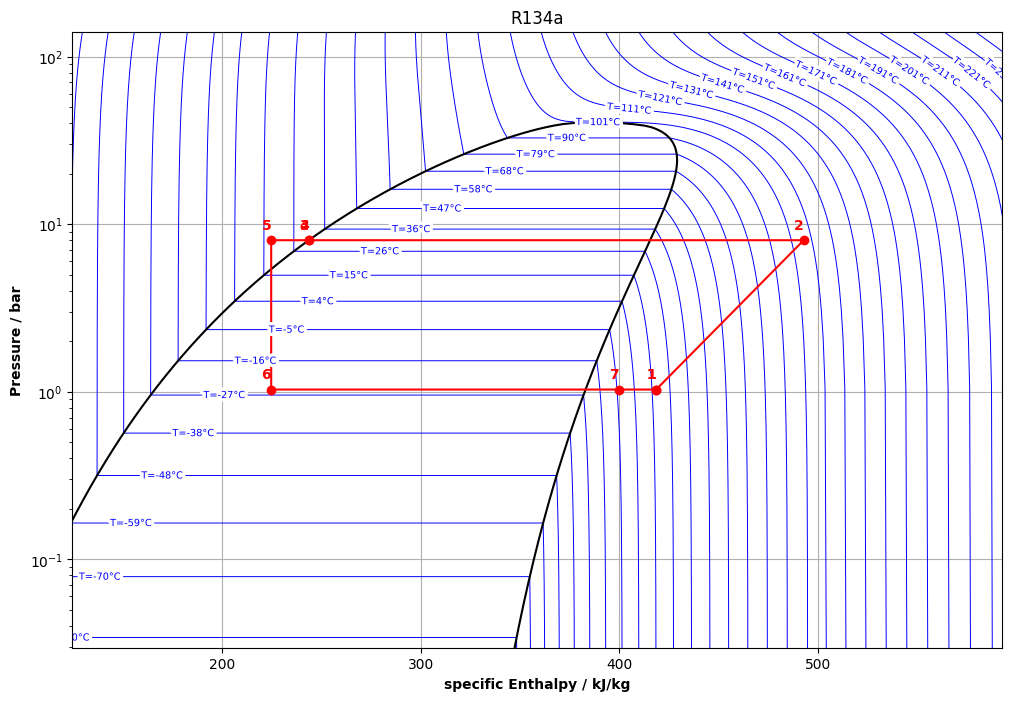

In [18]:
logph([[h1 * 1e-3, h2 * 1e-3, h3 * 1e-3, h4 * 1e-3, h5 * 1e-3, h6 * 1e-3, h7 * 1e-3, h1 * 1e-3]],
      [[p1 * 1e-5, p2 * 1e-5, p3 * 1e-5, p4 * 1e-5, p5 * 1e-5, p6 * 1e-5, p7 * 1e-5, p1 * 1e-5]],
      [[1, 2, 3, 4, 5, 6, 7, 1]],
      [net.fluid_loops[1]])

## Inverse Problem

...

In [19]:
net.set_parameter("Comp", "RPM", value=2500, is_var=True, scale_factor=1.0e-3, bounds=(750, 3500))
net.set_parameter("Exp", "Av", value=0.3, is_var=True, scale_factor=1.0, bounds=(0.1, 1.0))


def supheat_con(net):
    SH_value = 5.0
    T_sat = PropsSI('T', 'P', net.components['Evap'].ports["out_r"].p.value,
                    'Q', 1.0, net.components['Evap'].ports["out_r"].fluid)
    h_SH = PropsSI('H', 'T', T_sat + SH_value,
                   'P', net.components['Evap'].ports["out_r"].p.value,
                   net.components['Evap'].ports["out_r"].fluid)
    res = np.abs(net.components['Evap'].ports["out_r"].h.value - h_SH)
    return res

def cool_load_con(net):
    Qsp = 18000
    Q = net.components['Evap'].outputs['Q'].value
    res = np.abs(Q - Qsp)
    return res

net.add_constraint('superheat_constraint', supheat_con, ctype='obj', weight_factor=1e-5)
net.add_constraint('cooling_load_constraint', cool_load_con, ctype='obj', weight_factor=1e-3)


net.solve_system_notebook()




 Start solver...
Residual norm = 1.408e+00, Obj = 1.458e+01
Residual norm = 1.520e-01, Obj = 4.262e+00
Residual norm = 4.949e-02, Obj = 8.012e-01
Residual norm = 5.152e-01, Obj = 9.945e+00
Residual norm = 8.123e-03, Obj = 4.150e-01
Residual norm = 6.302e-03, Obj = 2.156e-01
Residual norm = 3.288e-01, Obj = 4.192e+00
Residual norm = 2.138e-01, Obj = 2.257e+00
Residual norm = 1.705e+00, Obj = 1.479e+01
Residual norm = 1.518e+00, Obj = 1.778e+01
Residual norm = 1.406e-04, Obj = 8.751e-03
Residual norm = 2.564e-06, Obj = 3.682e-03
Residual norm = 1.285e-03, Obj = 2.686e-02
Residual norm = 2.377e-02, Obj = 3.785e-01
Residual norm = 2.247e-08, Obj = 9.270e-04
Residual norm = 2.086e-08, Obj = 5.737e-04
Residual norm = 4.431e-11, Obj = 1.618e-05
Residual norm = 2.167e-12, Obj = 6.012e-06
Residual norm = 5.128e-09, Obj = 9.318e-04
Residual norm = 1.263e-07, Obj = 4.657e-03
Residual norm = 8.554e-13, Obj = 2.222e-07
Optimization terminated successfully    (Exit mode 0)
            Current funct

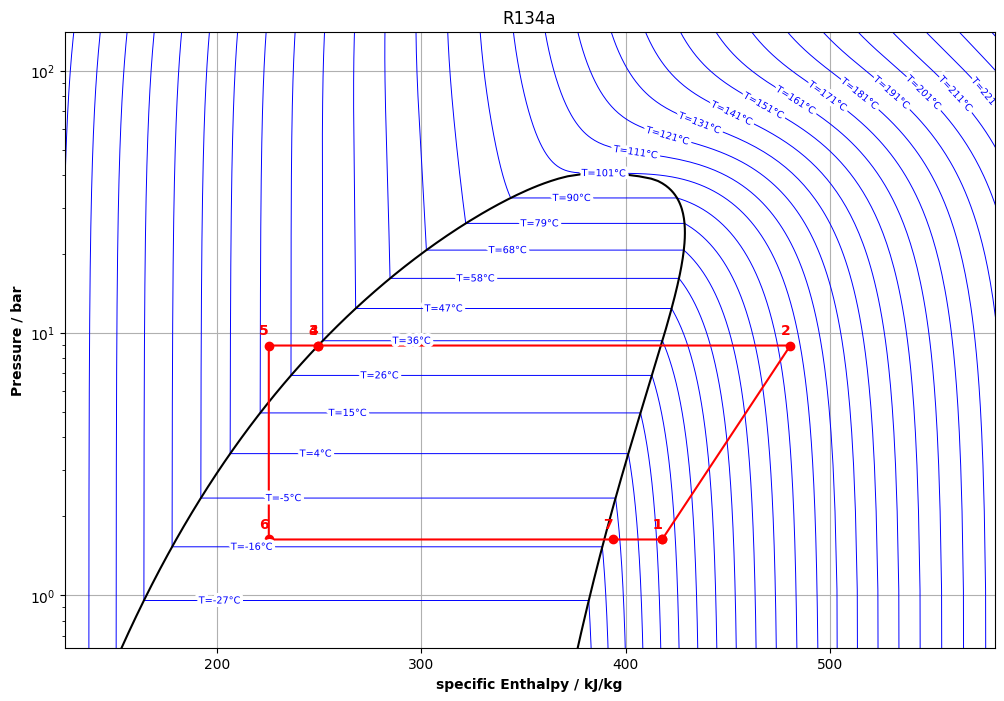

In [20]:
res_inv = net.get_results()

p1 = res_inv["ports"]["Comp"]["in"]["p"]
p2 = res_inv["ports"]["Comp"]["out"]["p"]
h1 = res_inv["ports"]["Comp"]["in"]["h"]
h2 = res_inv["ports"]["Comp"]["out"]["h"]

p3 = res_inv["ports"]["Cond"]["out_r"]["p"]
h3 = res_inv["ports"]["Cond"]["out_r"]["h"]

p4 = res_inv["ports"]["Rev"]["out"]["p"]
h4 = res_inv["ports"]["Rev"]["out"]["h"]

p5 = res_inv["ports"]["IHX"]["out_hot"]["p"]
h5 = res_inv["ports"]["IHX"]["out_hot"]["h"]

p6 = res_inv["ports"]["Exp"]["out"]["p"]
h6 = res_inv["ports"]["Exp"]["out"]["h"]

p7 = res_inv["ports"]["Evap"]["out_r"]["p"]
h7 = res_inv["ports"]["Evap"]["out_r"]["h"]


logph([[h1 * 1e-3, h2 * 1e-3, h3 * 1e-3, h4 * 1e-3, h5 * 1e-3, h6 * 1e-3, h7 * 1e-3, h1 * 1e-3]],
      [[p1 * 1e-5, p2 * 1e-5, p3 * 1e-5, p4 * 1e-5, p5 * 1e-5, p6 * 1e-5, p7 * 1e-5, p1 * 1e-5]],
      [[1, 2, 3, 4, 5, 6, 7, 1]],
      [net.fluid_loops[1]])